In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, accuracy_score


In [2]:
# Read in data sets - first set has denver data with outliers removed and encoded. Next set has ID and classification groupings.
df = pd.read_csv('1_denver_no_outliers_encoded_not_scaled.csv')

segments = pd.read_csv("1_pca_kmeans_seg.csv")


In [3]:
# segments.head()

rows = len(segments)
rows2 = len(df)
print({rows})
print({rows2})

{3565}
{3565}


In [4]:
# Check for nulls in rf_data and encoded_id_df so no issues when join.
null_counts = df.isnull().sum().sort_values(ascending=False)
null_counts_over0 = null_counts[null_counts > 0]
null_counts2 = segments.isnull().sum().sort_values(ascending=False)
null_counts2_over0 = null_counts2[null_counts2 > 0]
print(null_counts_over0)
print(null_counts2_over0)

Series([], dtype: int64)
Series([], dtype: int64)


In [5]:
# merge encoded dataframe with rest of data by id

rf_classification_df = pd.merge(segments, df, on='id', how='inner')
rf_classification_df.head()



,id,customer_segments_pca,accommodates,bedrooms,beds,price,availability_30,availability_60,availability_90,availability_365,...,bath_number,prop_type_reduced_Entire condo,prop_type_reduced_Entire guest suite,prop_type_reduced_Entire guesthouse,prop_type_reduced_Entire home,prop_type_reduced_Entire rental unit,prop_type_reduced_Entire townhouse,prop_type_reduced_Other,has_availability_f,has_availability_t
0,360,1,3,2.0,2.0,90.0,4,27,57,147,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,364,3,3,1.0,1.0,179.0,23,53,83,358,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,31503,3,2,1.0,1.0,103.0,12,42,72,347,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,39405,0,2,1.0,1.0,136.0,6,7,32,114,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,154999,1,2,1.0,1.0,162.0,0,0,0,139,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
# Check for nulls in rf_data and encoded_id_df so no issues when join.
rf_nulls = rf_classification_df.isnull().sum().sort_values(ascending=False)
rf_nulls_over0 = rf_nulls[rf_nulls > 0]

print(rf_nulls_over0)


Series([], dtype: int64)


In [7]:
# Set id as index so can retain id through the split and prediction process
rf_classification_df= rf_classification_df.set_index('id')

Below section builds the random forest classification model.

We will use this to predict the segment classification.

In [8]:
##### random forest no need to scale. Data is all numeric and already encoded as needed.

In [9]:
rf_classification_df.columns

Index(['customer_segments_pca', 'accommodates', 'bedrooms', 'beds', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'bath_number',
       'prop_type_reduced_Entire condo',
       'prop_type_reduced_Entire guest suite',
       'prop_type_reduced_Entire guesthouse', 'prop_type_reduced_Entire home',
       'prop_type_reduced_Entire rental unit',
       'prop_type_reduced_Entire townhouse', 'prop_type_reduced_Other',
       'has_availability_f', 'has_availability_t'],
      dtype='object')

In [10]:
# create x and y (drop customer segments pca)

X = rf_classification_df.copy()
X.drop('customer_segments_pca', axis=1, inplace=True)
y = rf_classification_df['customer_segments_pca']


In [11]:
# get y sets into array format
y.ravel()

array([1, 3, 3, ..., 1, 3, 1], dtype=int64)

In [12]:
# train_test_split on x and y 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [13]:
# create and fit random forest classification model 
rf_class_model = RandomForestClassifier(n_estimators=200, random_state=1)

rf_class_model = rf_class_model.fit(X_train, y_train)


In [14]:
# make predictions

y_pred_class = rf_class_model.predict(X_test)


In [15]:
# calculate accuracy score

acc_score = accuracy_score(y_test, y_pred_class)


# Display results
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.9237668161434978


In [16]:
# Print classification reports
print(f"Classification Report")
print(classification_report(y_test, y_pred_class))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       178
           1       0.92      0.95      0.93       277
           2       0.92      0.65      0.76        17
           3       0.90      0.94      0.92       237
           4       0.96      0.94      0.95       183

    accuracy                           0.92       892
   macro avg       0.92      0.87      0.89       892
weighted avg       0.92      0.92      0.92       892



In [18]:
# Get the feature importance array for availability and rating

feature_importances_segment = rf_class_model.feature_importances_


In [28]:
# Create sorted dataframe of availability features and importance scores
feature_names_segment = X_train.columns
importances_segment_df = pd.DataFrame({'Feature': feature_names_segment, 'Importance': feature_importances_segment })
importances_segment_df_sorted = importances_segment_df.sort_values(by='Importance', ascending=False)
importances_segment_df_sorted.head(15)

,Feature,Importance
5,availability_60,0.132801
9,number_of_reviews_ltm,0.118331
6,availability_90,0.095972
4,availability_30,0.090363
1,bedrooms,0.078060
10,number_of_reviews_l30d,0.072963
0,accommodates,0.059002
18,bath_number,0.044831
3,price,0.044400
2,beds,0.044031


In [49]:
sum_top_values = importances_segment_df_sorted['Importance'].head(12).sum()
print({sum_top_values})

{0.8597460707951622}


In [50]:
len(importances_segment_df_sorted)

28

In [21]:
importances_segment_df_sorted.sum()

Feature       availability_60number_of_reviews_ltmavailabili...
Importance                                                  1.0
dtype: object

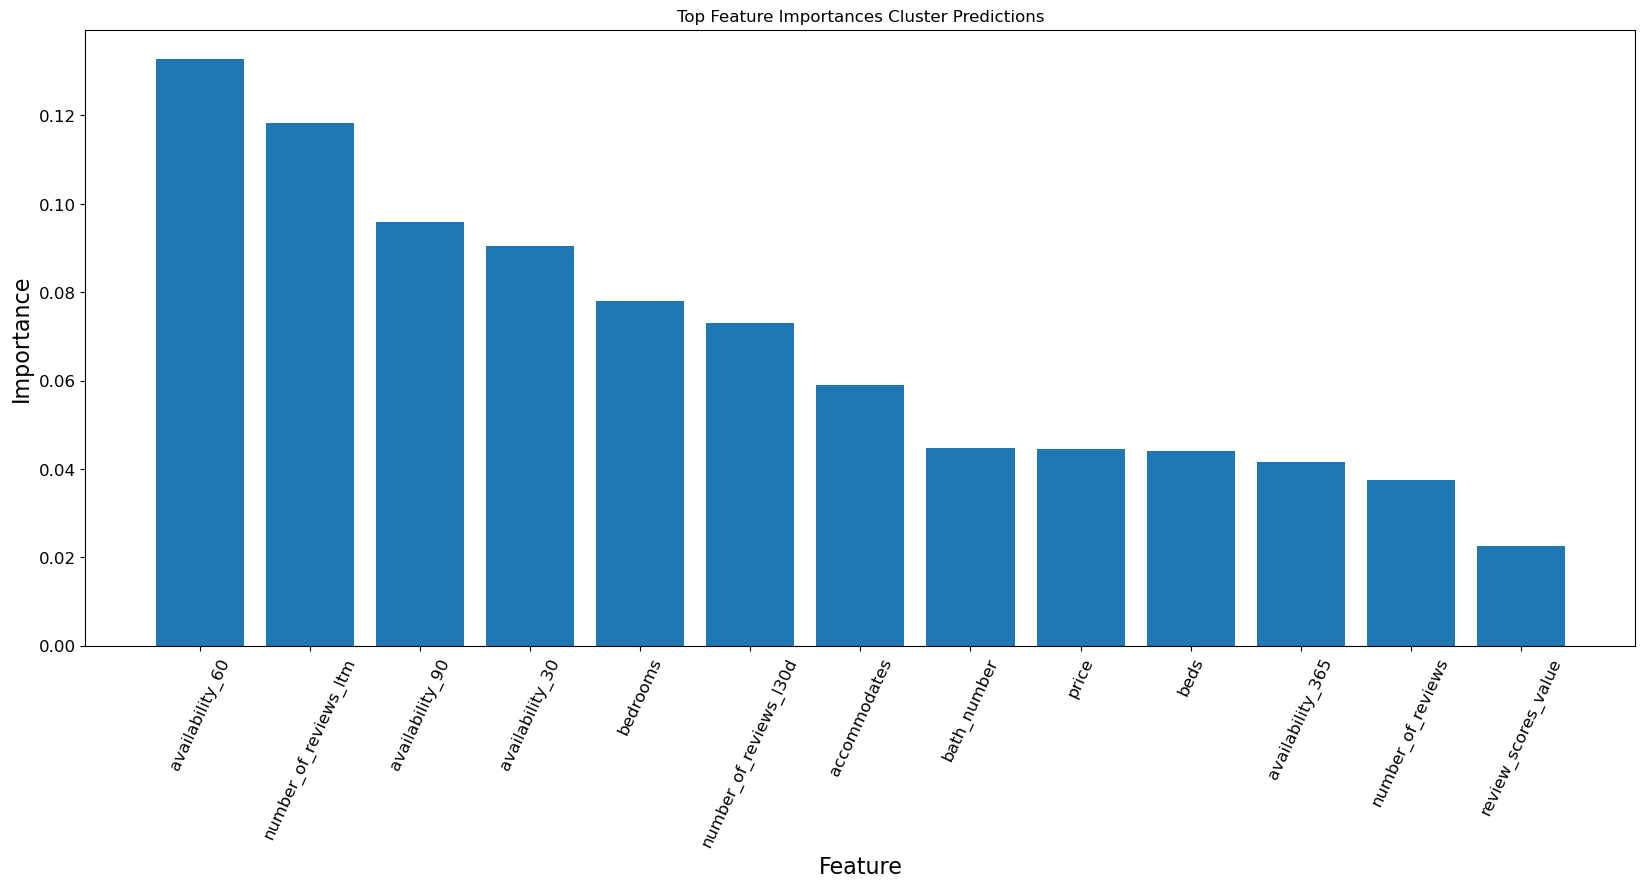

In [53]:
# plot top feature importances for segment classification

N = 13
top_features_segment = importances_segment_df_sorted.head(N)

plt.figure(figsize=(20, 8))
plt.bar(top_features_segment['Feature'], top_features_segment['Importance'])
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Importance', fontsize=16)
plt.title('Top Feature Importances Cluster Predictions')
plt.xticks(fontsize=12, rotation=65)  # Rotate x-ticks for better readability 
plt.yticks(fontsize=12)

plt.show()